<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/TEST_AAE_ROC_test_PED1_gt_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install imageio
!pip install qpsolvers
!pip install shapely 
#!pip install tensorflow_datasets
!pip install keras-layer-normalization
from google.colab import drive
#!pip install alive-progress
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [0]:


from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import skimage
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
	
import statistics
import shutil

import matplotlib.pyplot as plt

import time
#from progress.bar import IncrementalBar

import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Dropout, Activation, InputLayer
from keras.optimizers import Adam
from keras_layer_normalization import LayerNormalization
from keras.models import load_model
import csv
from scipy.interpolate import make_interp_spline, BSpline

from scipy.signal import savgol_filter

In [0]:
def get_single_test(single_test_path):
    
    sz = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
          sz = sz +1
    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            #print("img path: "+join(single_test_path, f))
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

def get_test_sequences(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    return sequences



def prepend_10_clips(test_cases):
    test_aug = []
    test_aug.extend(test_cases[0:10])
    test_aug.extend(test_cases)
    return test_aug


In [0]:
class Config:
    def __init__(self, data_dir_, cwdir_name_, data_set):
        self.data_set_name = data_set
        self.data_dir = data_dir_
        self.data_set_dir = join(self.data_dir, data_set)
        self.cwdir_name = cwdir_name_
        self.cwdir = join(self.data_dir,self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")
        if not os.path.exists(self.cwdir):
            os.mkdir(self.cwdir)
            os.mkdir(self.run_data)
    
        if not os.path.exists(self.run_data):
            #shutil.rmtree(self.run_data)
            os.mkdir(self.run_data)
            os.makedirs(self.image_dir, exist_ok=True)

        self.DATASET_PATH = join(self.data_set_dir,"Train/")
        self.TEST_DIR = join(self.data_set_dir,"Test/")
        self.BATCH_SIZE = 2
        self.EPOCHS = 50
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = 0
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1
        self.latent_dim = 327680


    def reconfig(self, new_name, batch_size = 4, epochs = 5, retrain = 0):
        self.cwdir_name = new_name
        self.cwdir = join(self.data_dir, self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")

        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = retrain
        if retrain == 0:
            print("Configuring train from scratch")
            if not os.path.exists(self.cwdir):
                os.mkdir(self.cwdir)
                os.mkdir(self.run_data)
    
            if os.path.exists(self.run_data):
                shutil.rmtree(self.run_data)
                os.mkdir(self.run_data)
                os.makedirs(self.image_dir, exist_ok=True)


conf = Config(data_dir_="/content/drive/My Drive/", cwdir_name_="Conv2DLSTM_AAE_PED1", data_set="UCSD_Anomaly_Dataset.v1p2/UCSDped1/") 


In [0]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/drive/My Drive/Persistence1D/python')


import matplotlib.pyplot as plt
import numpy as np
from persistence1d import RunPersistence
from reconstruct1d import RunReconstruction
import math    

from shapely.geometry import LineString

In [0]:
TestVideoFile_ped1 = list((36,2))
end = 200
#TestVideoFile_ped1_ori = [[60,152], [50,175], [91,end], [31,168], [5,90], [1,100], [1,175], [1,94], [1,48], [1,140],   [70,165],   [130,end],   [1,156],   [1,end],   [138,end],   [123,end],   [1,47],   [54,120],    [64,138],    [45,175],    [31,end],    [16,107],    [8,165],    [50,171],    [40,135],    [77,144],    [10,122],    [105,end],    [1,15],    [175,end],    [1,180],    [1,52],  [5,165],    [1,121],    [86,end],   [15,108]]


TestVideoFile_ped1 = [[60,152], [50,175], [91,end], [1,168], [5,139], [1,100], [1,175], [1,94], [1,48], [1,140],   [115,end],   [130,end],   [1,156],   [1,end],   [138,end],   [50, 60],   [1,47],   [54,120],    [64,138],    [45,175],    [31,end],    [16,107],    [8,end],    [1,171],    [40,135],    [77,end],    [10,122],    [105,end],    [1,15],    [175,end],    [1,180],    [1,52],  [1,175],    [1,121],    [86,end],   [15,108]]



def SortExtremaByPersistence(ExtremaAndPersistence):
    #~ Sort the list of extrema by persistence.
    #~ The original list from RunPersistence() is not guaranteed to be sorted,
    #~ although it may appear sorted in many cases.
    #~ This call to sorted() creates a new list. If you want to sort in-place, use ExtremaAndPersistence.sort()
    SortedExtremaAndPersistence = sorted(ExtremaAndPersistence, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[0])
    return SortedExtremaAndPersistence

def GetMinima(ExtremaAndPersistence):
    Minima = [t for t in ExtremaAndPersistence[::2]]
    return Minima

def GetMaxima(ExtremaAndPersistence):
    Maxima = [t for t in ExtremaAndPersistence[1::2]]
    return Maxima


def GetIntersection(x, f, g):

    plt.plot(x, f)
    plt.plot(x, g)

    first_line = LineString(np.column_stack((x, f)))
    second_line = LineString(np.column_stack((x, g)))
    intersection = first_line.intersection(second_line)
    print("Intersection")
    #print(intersection)
    x_list = []
    if intersection.geom_type == 'MultiPoint':
        plt.plot(*LineString(intersection).xy, 'o')
        print("Multipoint")
        print(*LineString(intersection).xy[0])
        for x_point in LineString(intersection).xy[0]:
            x_list.append(x_point)
    elif intersection.geom_type == 'Point':
        plt.plot(*intersection.xy, 'o')
        print("Point")
        print(*intersection.xy[0])
        x_list.append(*intersection.xy[0])

    x_arr = np.array(x_list)
    #print("X_LIST")
    #print(x_arr)
    return x_arr
    #all(i >= 30 for i in g[])

def find_overlap_rate(reference, detection):

    overlap = 0
    for x, y in detection:

        print("Intersect x, y   =   "+str(x)+" , "+str(y))
        for p, q in reference:
            print("Reference p, q   =   "+str(p)+" , "+str(q))
            if y > p and x < q:
                overlap = overlap+ abs(min(y,q) - max(x,p))

    print("Overlap: "+str(overlap))

    return overlap


def persistence(InputData, dt, id, color):
    #~ Compute the extrema of the given data and their persistence.
    ExtremaAndPersistence = RunPersistence(InputData)

    #~ Keep only those extrema with a persistence larger than 0.5.
    FilteredIndices = [t[0] for t in ExtremaAndPersistence if t[1] >= 0.1]

    #~ This simple call is all you need to reconstruct a smooth function containing only the filtered extrema
    SmoothData = RunReconstruction(InputData, FilteredIndices, 'biharmonic', 0.0000001)
    #print("Smooth data ")
    #print(SmoothData)

    x = np.array([x for x in range(0, InputData.shape[0])])
    
    g = SmoothData
    

    ##add gt_tuples : TODO
    
    #print(intersections)
    #~ Plot original and smoothed data
    fig, ax = plt.subplots()
    ax.plot(range(0, len(InputData)), InputData, label="Original Data", color="blue")
    ax.plot(range(0, len(SmoothData)), SmoothData, label="Smooth Data", color="orange")
    ExtremaIndices = [t[0] for t in ExtremaAndPersistence]
    
    """
    sorted_extr = SortExtremaByPersistence(ExtremaAndPersistence)
    minima = SortExtremaByPersistence(GetMinima(ExtremaAndPersistence))
    maxima = SortExtremaByPersistence(GetMaxima(ExtremaAndPersistence))
    print("###########Print All Extremas#################")

  
    print([t for t in ExtremaAndPersistence])

    print("###########Print Filtered Extremas#################")

    print([t for t in FilteredIndices])

    print("###########Print Sorted Extremas#################")

    print([t for t in sorted_extr])

    print("###########Print Minimas#################")

    print([t for t in minima])

    print("###########Print Maximas#################")

    print([t for t in maxima])
    """


    gt_tuples = []
    ax.plot(ExtremaIndices, InputData[ExtremaIndices], marker='.', linestyle='')
    ax.plot(FilteredIndices, InputData[FilteredIndices], marker='*', linestyle='')
    ax.set(xlabel='data index', ylabel='data value')
    #ax.set_aspect(1.0/ax.get_data_ratio()*0.2)
    plt.axvspan(TestVideoFile_ped1[id-1][0]-1, TestVideoFile_ped1[id-1][1]-1, alpha=0.5, color=color)
    #plt.axhline(y=threshold_abs,linewidth=1, color='blue') 


    gt_tuples.append((TestVideoFile_ped1[id-1][0]-1, TestVideoFile_ped1[id-1][1]-1))
    if dt == 1 and id == 5:
        plt.axvspan(140-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((140-1, end-1))
    elif dt == 1 and id == 6:
        plt.axvspan(110-1, end-1, alpha=0.5, color=color) 
        gt_tuples.append((110-1, end-1))
    if dt == 1 and id == 8:
        plt.axvspan(150-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((150-1, end-1))
    if dt == 1 and id == 16:
        plt.axvspan(123-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((123-1, end-1))
    if dt == 1 and id == 18:
        plt.axvspan(160-1, 195-1, alpha=0.5, color=color)
        gt_tuples.append((160-1, 195-1))
    if dt == 1 and id == 22:
        plt.axvspan(172-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((172-1, end-1))
    elif dt == 1 and id == 29:
        plt.axvspan(45-1, 113-1, alpha=0.5, color=color)
        gt_tuples.append((45-1, 113-1))
    elif dt == 1 and id == 32:
        plt.axvspan(65-1, 115-1, alpha=0.5, color=color)
        gt_tuples.append((65-1, 115-1))

    gt_inverse_tuples = []

    gti_start = 0
    for p, q in gt_tuples:
        if(p == gti_start):
            gti_start = q
            continue
        gt_inverse_tuples.append((gti_start, p))
        gti_start = q

    if gti_start < end-1:
        gt_inverse_tuples.append((gti_start, end-1))

    print("GT Tuples: "+str(gt_tuples))
    print("GT Inverse Tuples: "+str(gt_inverse_tuples))

    TPR_ARR = []
    FPR_ARR = []

    for threshold_abs in np.arange(0.4, 1.05, 0.05):
        f = np.ones(x.shape[0])*threshold_abs
        intersections = [0]
        intersections.extend(GetIntersection(x, f, g))
        if(intersections[len(intersections)-1] < end -1):
            intersections.extend([end-1])

        intersections = np.array(intersections)
        all_below_th = []
        #all_above_th = []

        for j, __ in enumerate(intersections):

            if all(i <= threshold_abs for i in g[math.ceil(intersections[j]): math.floor(intersections[j+1])]):
                all_below_th.append((intersections[j], intersections[j+1]))
                
            if(end - 1 == math.floor(intersections[j+1])):
                break
            #if all(i >= threshold_abs for i in g[math.ceil(intersections[j]): math.floor(intersections[j+1])]):
            #    all_above_th.append((intersections[j], intersections[j+1]))

        print("_________Find TPR FPR for Threshold : "+str(threshold_abs)+"__________")
        print("============Find TPR============")
        TPR = find_overlap_rate(gt_tuples, all_below_th)
        print("============Find FPR============")
        FPR = find_overlap_rate(gt_inverse_tuples, all_below_th)

        TPR_ARR.append(TPR)
        FPR_ARR.append(FPR)
    
        print("TPR : "+str(TPR))
        print("FPR : "+str(FPR))
        print("\n\n\n")
    
    total_ref_gt = 0
    for p, q in gt_tuples:
        total_ref_gt = total_ref_gt+ abs(q-p)
    print("Total GT: "+str(total_ref_gt))
    total_ref_gti = 0
    for p, q in gt_inverse_tuples:
        total_ref_gti = total_ref_gti+ abs(q-p)
    print("Total GT Inv: "+str(total_ref_gti))

    ax.grid()
    #ax.plot()

    plt.legend()    
    plt.show()

    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti

threshold = 0.9
def fill_gt_ped1(sr, id, color):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    print(sr.shape)
    #zeros = np.zeros((conf.dim1,))
    #print(zeros.shape)
    #plt.plot(np.concatenate((zeros, sr)))
    #persistence(sr, 1, id, color)
    #yhat = savgol_filter(sr, 51, 3)
    #TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(yhat, 1, id, color)
    TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(sr, 1, id, color)
    #plt.plot(sr)  
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti



TestVideoFile_ped2 = list((12,2))
TestVideoFile_ped2 = [[61,180],[95,180],[1,146],[31,180],[1,129],[1,159],[46,180],[1,180],[1,120],[1,150],[1,180],[88,180]]

def fill_gt_ped2(sr, id, color):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    #plt.plot(np.concatenate((np.zeros((conf.dim1,)), sr)))
    persistence(sr, 2, id, color)
    yhat = savgol_filter(sr, 51, 3)
    TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(yhat, 2, id, color)
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti





/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_9 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_10 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_11 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

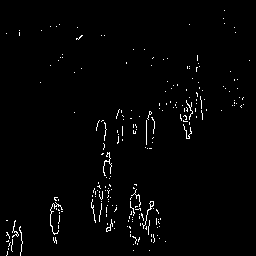

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test001 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(59, 151)]
GT Inverse Tuples: [(0, 59), (151, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
113.82582992371951 127.16327036443684
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   113.82582992371951 , 127.16327036443684
Reference p, q   =   59 , 151
Overlap: 13.33744044071733
============Find FPR============
Intersect x, y   =   113.82582992371951 , 127.16327036443684
Reference p, q   =   0 , 59
Reference p, q   =   151 , 199
Overlap: 0
TPR : 13.33744044071733
FPR : 0




Intersection
Multipoint
53.2794854567045 66.17456645945536 103.48787782241601 129.79520929347885 144.1190704369015 153.1561814640406 177.4523642118188 186.3953494289

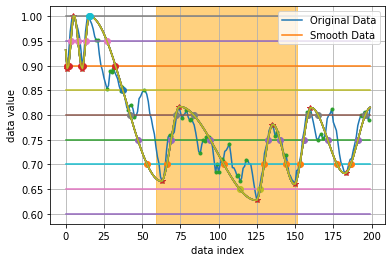

BGS show(200, 256, 256, 1)


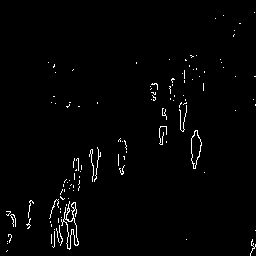

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test002 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(49, 174)]
GT Inverse Tuples: [(0, 49), (174, 199)]
Intersection
Multipoint
58.65542875300342 90.01482546865857 139.07796786535 155.57017938356415
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   58.65542875300342 , 90.01482546865857
Reference p, q   =   49 , 174
Intersect x, y   =   139.07796786535 , 155.57017938356415
Reference p, q   =   49 , 174
Overlap: 47.851608233869314
============Find FPR============
Intersect x, y   =   58.65542875300342 , 90.01482546865857
Reference p, q   =   0 , 49
Reference p, q   =   174 , 199
Intersect x, y   =   139.07796786535 , 155.57017938356415
Reference p, q   =   0 , 49
Reference p, q   =   174 , 199
Overlap: 0
TPR : 47.851608233869314
FPR : 0




Intersection
Multipoint
51.19530243688441 94.75150128681543 131.55710615658228 172.10661512147232
_____

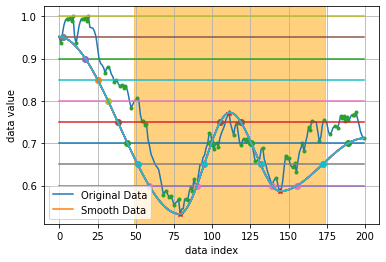

BGS show(200, 256, 256, 1)


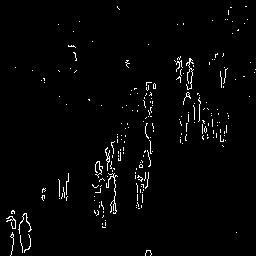

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test003 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(90, 199)]
GT Inverse Tuples: [(0, 90)]
Intersection
Point
105.60201655260528
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   105.60201655260528 , 199.0
Reference p, q   =   90 , 199
Overlap: 93.39798344739472
============Find FPR============
Intersect x, y   =   105.60201655260528 , 199.0
Reference p, q   =   0 , 90
Overlap: 0
TPR : 93.39798344739472
FPR : 0




Intersection
Point
95.387657095849
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   95.387657095849 , 199.0
Reference p, q   =   90 , 199
Overlap: 103.612342904151
============Find FPR============
Intersect x, y   =   95.387657095849 , 199.0
Reference p, q   =   0 , 90
Overlap: 0
TPR : 103.612342904151
FPR : 0




Intersection
Point
85.41843226264817
_________Find TPR FPR

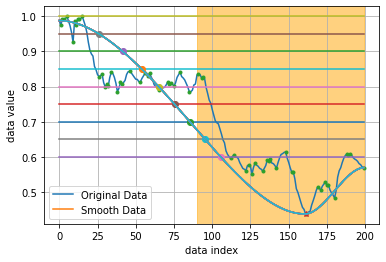

BGS show(200, 256, 256, 1)


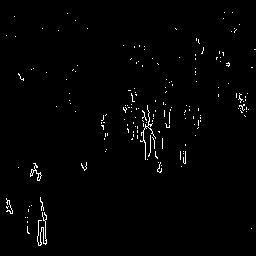

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test004 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(30, 167)]
GT Inverse Tuples: [(0, 30), (167, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
58.05725811631631 70.04416586793663
_________Find TPR FPR for Threshold : 0.7000000000000001__________
============Find TPR============
Intersect x, y   =   58.05725811631631 , 70.04416586793663
Reference p, q   =   30 , 167
Overlap: 11.986907751620315
============Find FPR============
Intersect x, y   =   58.05725811631631 , 70.04416586793663
Reference p, q   =   0 , 30
Reference p, q   =   167 , 199
Overlap: 0
TPR : 11.986907751

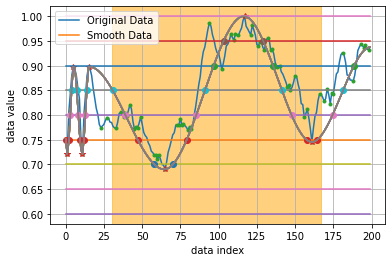

BGS show(200, 256, 256, 1)


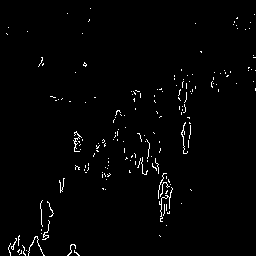

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test005 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(4, 89), (139, 199)]
GT Inverse Tuples: [(0, 4), (89, 139)]
Intersection
Multipoint
138.47623664107792 176.14665582991896
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   138.47623664107792 , 176.14665582991896
Reference p, q   =   4 , 89
Reference p, q   =   139 , 199
Overlap: 37.146655829918956
============Find FPR============
Intersect x, y   =   138.47623664107792 , 176.14665582991896
Reference p, q   =   0 , 4
Reference p, q   =   89 , 139
Overlap: 0.523763358922082
TPR : 37.146655829918956
FPR : 0.523763358922082




Intersection
Point
132.4757894263747
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   132.4757894263747 , 199.0
Reference p, q   =   4 , 89
Reference p, q   =   139 , 199
Overlap: 60.0
============Find FPR=======

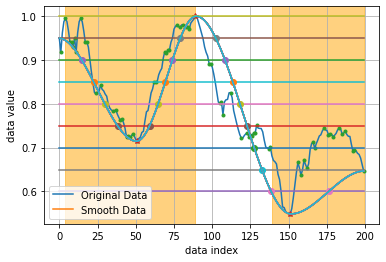

BGS show(200, 256, 256, 1)


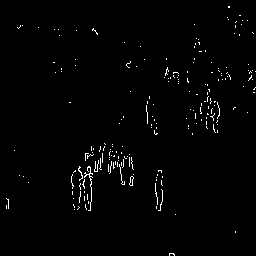

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test006 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 99), (109, 199)]
GT Inverse Tuples: [(99, 109)]
Intersection
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.7000000000000001__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
2.340846139091741 10.0195409251587 13.24013409864291
_________Find TPR FPR for Threshold : 0.7500000000000001__________
============Find TPR============
Intersect x, y   =   0.0 , 2.340846139091741
Reference p, q   =   0 , 99
Reference p, q   = 

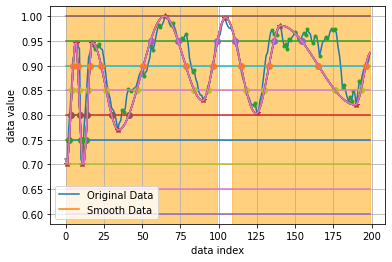

BGS show(200, 256, 256, 1)


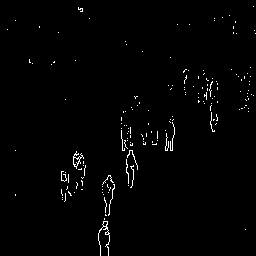

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test007 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 174)]
GT Inverse Tuples: [(174, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
97.09799675033928 102.91261553166359
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   97.09799675033928 , 102.91261553166359
Reference p, q   =   0 , 174
Overlap: 5.814618781324313
============Find FPR============
Intersect x, y   =   97.09799675033928 , 102.91261553166359
Reference p, q   =   174 , 199
Overlap: 0
TPR : 5.814618781324313
FPR : 0




Intersection
Multipoint
32.29632014809188 41.96800444224688 86.33658478734516 110.66034901029109
_________Find TPR FPR for Threshold : 0.7000000000000001__________
============Find TPR============
Intersect 

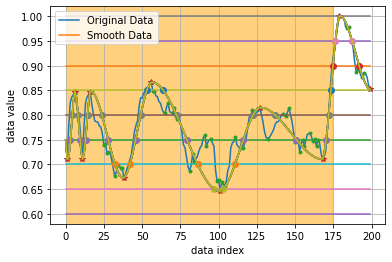

BGS show(200, 256, 256, 1)


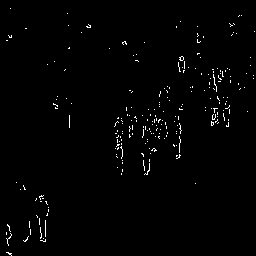

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test008 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 93)]
GT Inverse Tuples: [(93, 199)]
Intersection
Multipoint
63.87598557307027 99.71469490602742
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   63.87598557307027 , 99.71469490602742
Reference p, q   =   0 , 93
Overlap: 29.124014426929733
============Find FPR============
Intersect x, y   =   63.87598557307027 , 99.71469490602742
Reference p, q   =   93 , 199
Overlap: 6.714694906027418
TPR : 29.124014426929733
FPR : 6.714694906027418




Intersection
Multipoint
54.23939150582441 103.2146515116679
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   54.23939150582441 , 103.2146515116679
Reference p, q   =   0 , 93
Overlap: 38.76060849417559
============Find FPR============
Intersect x, y   =   54.23939150582441 , 103.2146515116679
Re

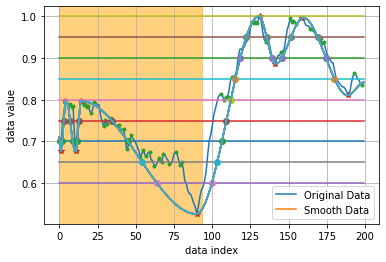

BGS show(200, 256, 256, 1)


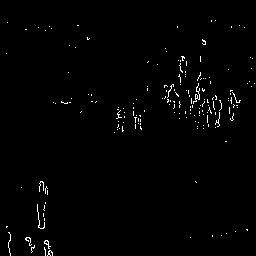

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test009 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 47)]
GT Inverse Tuples: [(47, 199)]
Intersection
Multipoint
27.188868782705995 36.911728303035595
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   27.188868782705995 , 36.911728303035595
Reference p, q   =   0 , 47
Overlap: 9.7228595203296
============Find FPR============
Intersect x, y   =   27.188868782705995 , 36.911728303035595
Reference p, q   =   47 , 199
Overlap: 0
TPR : 9.7228595203296
FPR : 0




Intersection
Multipoint
24.463794927304143 42.495399052760604 74.4293771051206 98.05117442749935
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   24.463794927304143 , 42.495399052760604
Reference p, q   =   0 , 47
Intersect x, y   =   74.4293771051206 , 98.05117442749935
Reference p, q   =   0 , 47
Overlap: 18.03160412545646
=

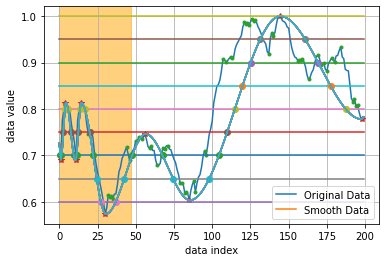

BGS show(200, 256, 256, 1)


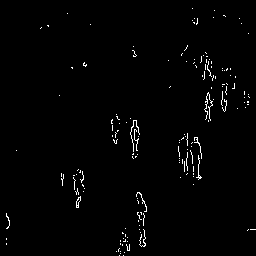

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test010 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 139)]
GT Inverse Tuples: [(139, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
41.14599249367068 50.34889278575797
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   41.14599249367068 , 50.34889278575797
Reference p, q   =   0 , 139
Overlap: 9.202900292087286
============Find FPR============
Intersect x, y   =   41.14599249367068 , 50.34889278575797
Reference p, q   =   139 , 199
Overlap: 0
TPR : 9.202900292087286
FPR : 0




Intersection
Multipoint
36.13805645595488 52.563996686506 72.60799452877487 74.72521458563963
_________Find TPR FPR for Threshold : 0.7000000000000001__________
============Find TPR============
Intersect x, y  

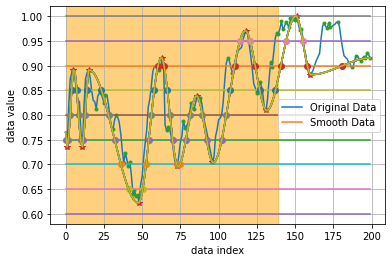

BGS show(200, 256, 256, 1)


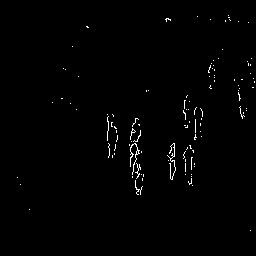

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test011 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(69, 164)]
GT Inverse Tuples: [(0, 69), (164, 199)]
Intersection
Point
183.44719167220939
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   183.44719167220939 , 199.0
Reference p, q   =   69 , 164
Overlap: 0
============Find FPR============
Intersect x, y   =   183.44719167220939 , 199.0
Reference p, q   =   0 , 69
Reference p, q   =   164 , 199
Overlap: 15.552808327790615
TPR : 0
FPR : 15.552808327790615




Intersection
Point
176.888874140186
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   176.888874140186 , 199.0
Reference p, q   =   69 , 164
Overlap: 0
============Find FPR============
Intersect x, y   =   176.888874140186 , 199.0
Reference p, q   =   0 , 69
Reference p, q   =   164 , 199
Overlap: 22.111125859813995
TPR : 0
FPR 

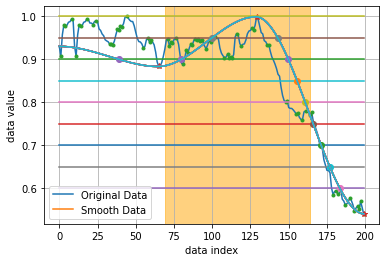

BGS show(200, 256, 256, 1)


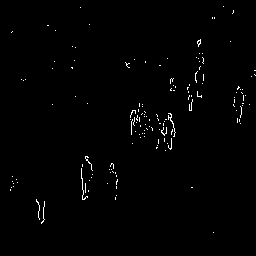

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test012 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(129, 199)]
GT Inverse Tuples: [(0, 129)]
Intersection
Multipoint
113.73840115936055 116.15733354268087
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   113.73840115936055 , 116.15733354268087
Reference p, q   =   129 , 199
Overlap: 0
============Find FPR============
Intersect x, y   =   113.73840115936055 , 116.15733354268087
Reference p, q   =   0 , 129
Overlap: 2.4189323833203247
TPR : 0
FPR : 2.4189323833203247




Intersection
Multipoint
112.40054837553089 116.44851504022635 157.42768023455022 169.8962806976273
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   112.40054837553089 , 116.44851504022635
Reference p, q   =   129 , 199
Intersect x, y   =   157.42768023455022 , 169.8962806976273
Reference p, q   =   129 , 199
Overlap:

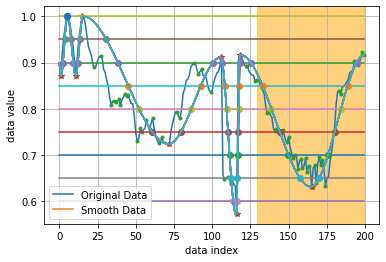

BGS show(200, 256, 256, 1)


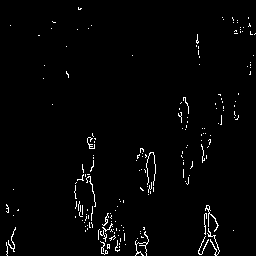

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test013 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 155)]
GT Inverse Tuples: [(155, 199)]
Intersection
Multipoint
101.91814558518473 116.53444795644391 130.32044284869778 141.7871736248635
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   101.91814558518473 , 116.53444795644391
Reference p, q   =   0 , 155
Intersect x, y   =   130.32044284869778 , 141.7871736248635
Reference p, q   =   0 , 155
Overlap: 26.0830331474249
============Find FPR============
Intersect x, y   =   101.91814558518473 , 116.53444795644391
Reference p, q   =   155 , 199
Intersect x, y   =   130.32044284869778 , 141.7871736248635
Reference p, q   =   155 , 199
Overlap: 0
TPR : 26.0830331474249
FPR : 0




Intersection
Multipoint
97.98102832509437 119.80879074389134 128.61998341439943 144.09926041584941
_________Find TPR FPR for Threshold : 0.65__________
===========

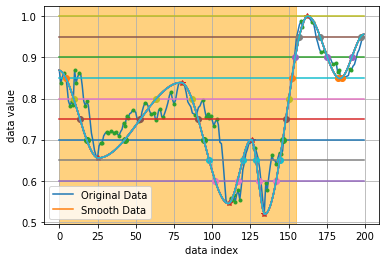

BGS show(200, 256, 256, 1)


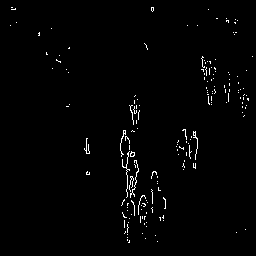

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test014 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 199)]
GT Inverse Tuples: []
Intersection
Multipoint
129.20961015409404 151.06267858571243
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   129.20961015409404 , 151.06267858571243
Reference p, q   =   0 , 199
Overlap: 21.853068431618397
============Find FPR============
Intersect x, y   =   129.20961015409404 , 151.06267858571243
Overlap: 0
TPR : 21.853068431618397
FPR : 0




Intersection
Multipoint
127.84656971380089 159.12944020200484
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   127.84656971380089 , 159.12944020200484
Reference p, q   =   0 , 199
Overlap: 31.282870488203955
============Find FPR============
Intersect x, y   =   127.84656971380089 , 159.12944020200484
Overlap: 0
TPR : 31.282870488203955
FPR : 0




Intersect

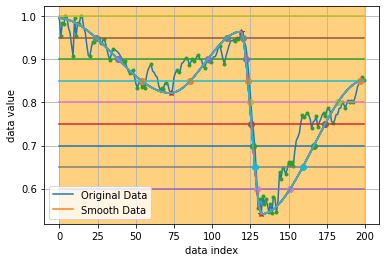

BGS show(200, 256, 256, 1)


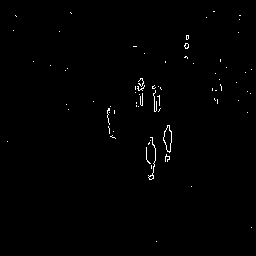

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test015 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(137, 199)]
GT Inverse Tuples: [(0, 137)]
Intersection
Multipoint
188.1763826855959 198.13831485689255
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   188.1763826855959 , 198.13831485689255
Reference p, q   =   137 , 199
Intersect x, y   =   198.13831485689255 , 199.0
Reference p, q   =   137 , 199
Overlap: 10.823617314404089
============Find FPR============
Intersect x, y   =   188.1763826855959 , 198.13831485689255
Reference p, q   =   0 , 137
Intersect x, y   =   198.13831485689255 , 199.0
Reference p, q   =   0 , 137
Overlap: 0
TPR : 10.823617314404089
FPR : 0




Intersection
Multipoint
158.79493150430557 173.79877443401625 186.87759926126432
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   158.79493150430557 , 173.7987744340

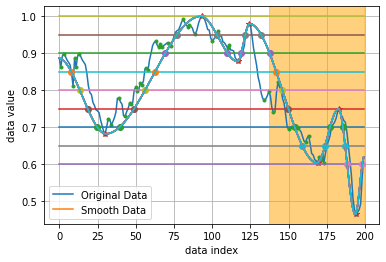

BGS show(200, 256, 256, 1)


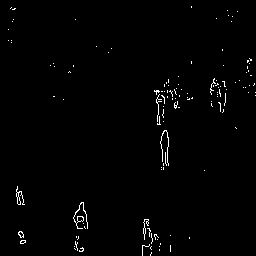

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test016 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(122, 199)]
GT Inverse Tuples: [(0, 122)]
Intersection
Multipoint
53.93521321670325 64.36719519495745 72.21435501559051 111.52271707828491 120.39345431079211 155.51549234239263
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   53.93521321670325 , 64.36719519495745
Reference p, q   =   122 , 199
Intersect x, y   =   72.21435501559051 , 111.52271707828491
Reference p, q   =   122 , 199
Intersect x, y   =   120.39345431079211 , 155.51549234239263
Reference p, q   =   122 , 199
Overlap: 33.51549234239263
============Find FPR============
Intersect x, y   =   53.93521321670325 , 64.36719519495745
Reference p, q   =   0 , 122
Intersect x, y   =   72.21435501559051 , 111.52271707828491
Reference p, q   =   0 , 122
Intersect x, y   =   120.39345431079211 , 155.51549234239263
Reference p, q   =   0 

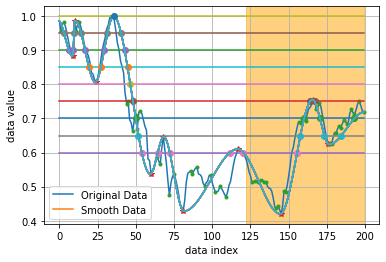

BGS show(200, 256, 256, 1)


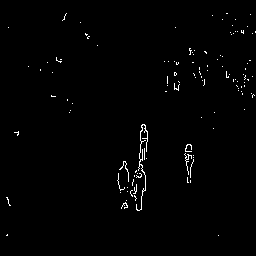

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test017 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 46)]
GT Inverse Tuples: [(46, 199)]
Intersection
Multipoint
40.48362643682448 61.009747856690076 150.0942751179642
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   40.48362643682448 , 61.009747856690076
Reference p, q   =   0 , 46
Intersect x, y   =   150.0942751179642 , 199.0
Reference p, q   =   0 , 46
Overlap: 5.51637356317552
============Find FPR============
Intersect x, y   =   40.48362643682448 , 61.009747856690076
Reference p, q   =   46 , 199
Intersect x, y   =   150.0942751179642 , 199.0
Reference p, q   =   46 , 199
Overlap: 63.915472738725875
TPR : 5.51637356317552
FPR : 63.915472738725875




Intersection
Multipoint
36.651024263539526 68.85553569672776 142.32226053500295
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   

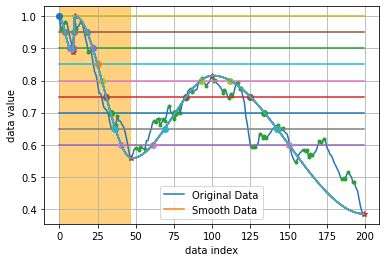

BGS show(200, 256, 256, 1)


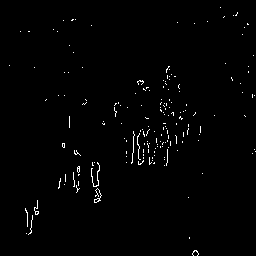

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test018 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(53, 119)]
GT Inverse Tuples: [(0, 53), (119, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
124.6957651385861 128.97234131825923 177.48157257611942
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   124.6957651385861 , 128.97234131825923
Reference p, q   =   53 , 119
Intersect x, y   =   177.48157257611942 , 199.0
Reference p, q   =   53 , 119
Overlap: 0
============Find FPR============
Intersect x, y   =   124.6957651385861 , 128.97234131825923
Reference p, q   =   0 , 53
Reference p, q   =   119 , 199
Intersect x, y   =   177.48157257611942 , 199.0
Reference p, q   =   0 , 53
Reference p, q   =   119 , 199
Overlap: 25.79500360355371


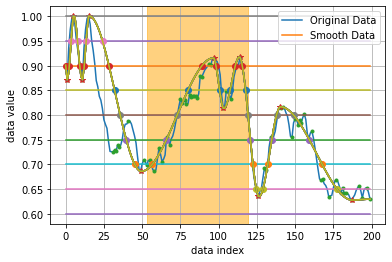

BGS show(200, 256, 256, 1)


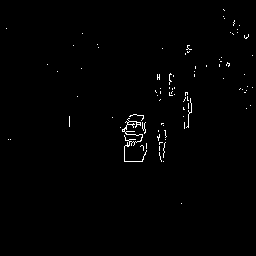

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test019 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(63, 137)]
GT Inverse Tuples: [(0, 63), (137, 199)]
Intersection
Multipoint
71.8067088214785 91.02944679755235 111.58279207684939 138.1629752724422
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   71.8067088214785 , 91.02944679755235
Reference p, q   =   63 , 137
Intersect x, y   =   111.58279207684939 , 138.1629752724422
Reference p, q   =   63 , 137
Overlap: 44.63994589922447
============Find FPR============
Intersect x, y   =   71.8067088214785 , 91.02944679755235
Reference p, q   =   0 , 63
Reference p, q   =   137 , 199
Intersect x, y   =   111.58279207684939 , 138.1629752724422
Reference p, q   =   0 , 63
Reference p, q   =   137 , 199
Overlap: 1.1629752724421962
TPR : 44.63994589922447
FPR : 1.1629752724421962




Intersection
Multipoint
59.67680923949696 95.30120553399819 108.6413

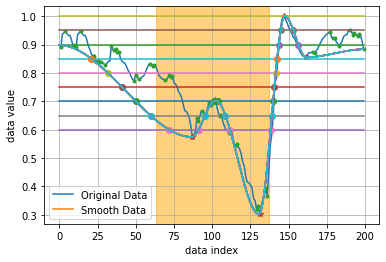

BGS show(200, 256, 256, 1)


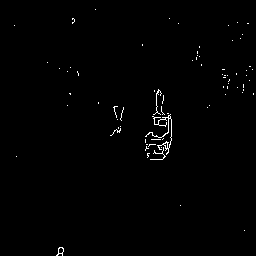

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test020 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(44, 174)]
GT Inverse Tuples: [(0, 44), (174, 199)]
Intersection
Multipoint
51.72354941622642 133.48156481972188
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   51.72354941622642 , 133.48156481972188
Reference p, q   =   44 , 174
Overlap: 81.75801540349546
============Find FPR============
Intersect x, y   =   51.72354941622642 , 133.48156481972188
Reference p, q   =   0 , 44
Reference p, q   =   174 , 199
Overlap: 0
TPR : 81.75801540349546
FPR : 0




Intersection
Multipoint
50.15616901652016 138.94261892073672
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   50.15616901652016 , 138.94261892073672
Reference p, q   =   44 , 174
Overlap: 88.78644990421657
============Find FPR============
Intersect x, y   =   50.15616901652016 , 138.

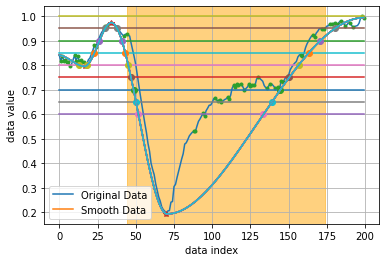

BGS show(200, 256, 256, 1)


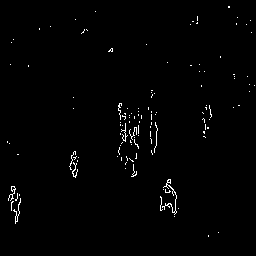

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test021 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(30, 199)]
GT Inverse Tuples: [(0, 30)]
Intersection
Multipoint
36.2645658034615 43.83185229673182 100.9993037868696 108.39098748549559
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   36.2645658034615 , 43.83185229673182
Reference p, q   =   30 , 199
Intersect x, y   =   100.9993037868696 , 108.39098748549559
Reference p, q   =   30 , 199
Overlap: 14.958970191896299
============Find FPR============
Intersect x, y   =   36.2645658034615 , 43.83185229673182
Reference p, q   =   0 , 30
Intersect x, y   =   100.9993037868696 , 108.39098748549559
Reference p, q   =   0 , 30
Overlap: 0
TPR : 14.958970191896299
FPR : 0




Intersection
Multipoint
33.835762846340934 46.078469902913625 80.02433086196994 114.98845090716448 166.46492147434031 179.92650754964143
_________Find TPR FPR for Threshold :

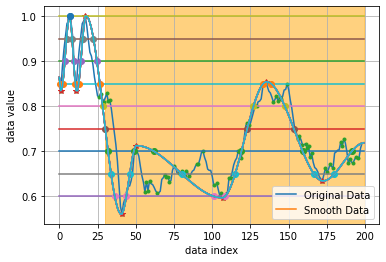

BGS show(200, 256, 256, 1)


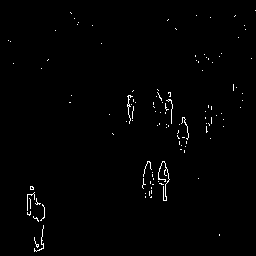

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test022 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(15, 106)]
GT Inverse Tuples: [(0, 15), (106, 199)]
Intersection
Multipoint
164.34252438431147 192.72882041560533
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   164.34252438431147 , 192.72882041560533
Reference p, q   =   15 , 106
Overlap: 0
============Find FPR============
Intersect x, y   =   164.34252438431147 , 192.72882041560533
Reference p, q   =   0 , 15
Reference p, q   =   106 , 199
Overlap: 28.386296031293853
TPR : 0
FPR : 28.386296031293853




Intersection
Multipoint
159.21568053005294 194.9958460321558
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   159.21568053005294 , 194.9958460321558
Reference p, q   =   15 , 106
Overlap: 0
============Find FPR============
Intersect x, y   =   159.21568053005294 , 194.9958460321

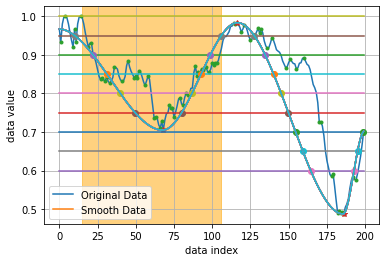

BGS show(200, 256, 256, 1)


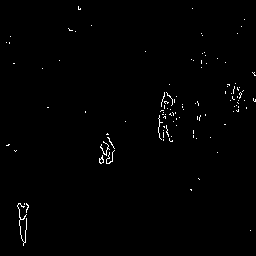

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test023 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(7, 164)]
GT Inverse Tuples: [(0, 7), (164, 199)]
Intersection
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
87.84854132200853 98.44942102277636
_________Find TPR FPR for Threshold : 0.7000000000000001__________
============Find TPR============
Intersect x, y   =   87.84854132200853 , 98.44942102277636
Reference p, q   =   7 , 164
Overlap: 10.600879700767834
============Find FPR============
Intersect x, y   =   87.84854132200853 , 98.44942102277636
Reference p, q   =   0 , 7
Reference p, q   =   164 , 199
Overlap: 0
TPR : 10.6008797007678

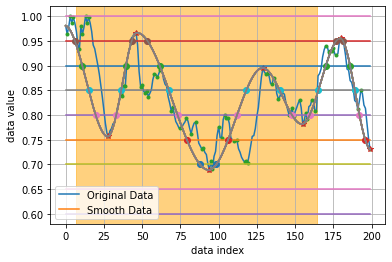

BGS show(200, 256, 256, 1)


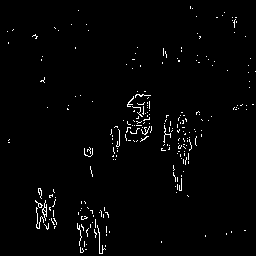

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test024 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(49, 170)]
GT Inverse Tuples: [(0, 49), (170, 199)]
Intersection
Multipoint
75.8824061305506 108.31905865931417 134.70506382471459 181.18964849969373
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   75.8824061305506 , 108.31905865931417
Reference p, q   =   49 , 170
Intersect x, y   =   134.70506382471459 , 181.18964849969373
Reference p, q   =   49 , 170
Overlap: 67.73158870404897
============Find FPR============
Intersect x, y   =   75.8824061305506 , 108.31905865931417
Reference p, q   =   0 , 49
Reference p, q   =   170 , 199
Intersect x, y   =   134.70506382471459 , 181.18964849969373
Reference p, q   =   0 , 49
Reference p, q   =   170 , 199
Overlap: 11.189648499693732
TPR : 67.73158870404897
FPR : 11.189648499693732




Intersection
Multipoint
63.74939869655338 113.96898233406515 1

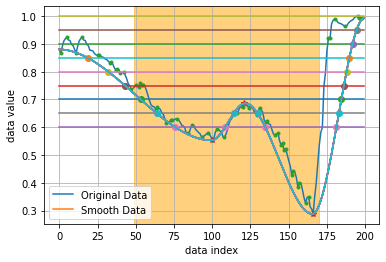

BGS show(200, 256, 256, 1)


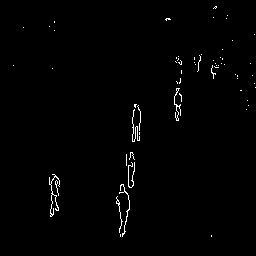

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test025 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(39, 134)]
GT Inverse Tuples: [(0, 39), (134, 199)]
Intersection
Multipoint
83.10301389129413 151.52454556452625
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   83.10301389129413 , 151.52454556452625
Reference p, q   =   39 , 134
Overlap: 50.896986108705875
============Find FPR============
Intersect x, y   =   83.10301389129413 , 151.52454556452625
Reference p, q   =   0 , 39
Reference p, q   =   134 , 199
Overlap: 17.52454556452625
TPR : 50.896986108705875
FPR : 17.52454556452625




Intersection
Multipoint
73.9581892397699 155.1834367605993
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   73.9581892397699 , 155.1834367605993
Reference p, q   =   39 , 134
Overlap: 60.041810760230106
============Find FPR============
Intersect x, y

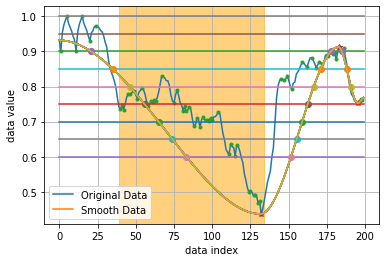

BGS show(200, 256, 256, 1)


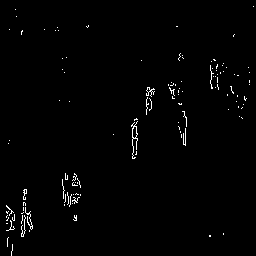

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test026 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(76, 143)]
GT Inverse Tuples: [(0, 76), (143, 199)]
Intersection
Point
162.60010944123857
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   162.60010944123857 , 199.0
Reference p, q   =   76 , 143
Overlap: 0
============Find FPR============
Intersect x, y   =   162.60010944123857 , 199.0
Reference p, q   =   0 , 76
Reference p, q   =   143 , 199
Overlap: 36.39989055876143
TPR : 0
FPR : 36.39989055876143




Intersection
Multipoint
81.62627795261444 98.08537914740725 154.28105182367423
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   81.62627795261444 , 98.08537914740725
Reference p, q   =   76 , 143
Intersect x, y   =   154.28105182367423 , 199.0
Reference p, q   =   76 , 143
Overlap: 16.459101194792808
============Find FPR=========

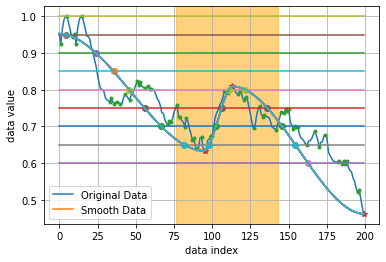

BGS show(200, 256, 256, 1)


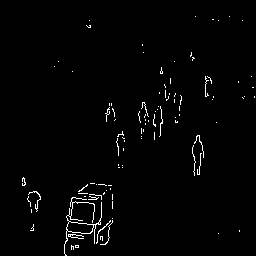

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test027 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(9, 121)]
GT Inverse Tuples: [(0, 9), (121, 199)]
Intersection
Multipoint
60.647289641422304 151.8682713601174
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   60.647289641422304 , 151.8682713601174
Reference p, q   =   9 , 121
Overlap: 60.352710358577696
============Find FPR============
Intersect x, y   =   60.647289641422304 , 151.8682713601174
Reference p, q   =   0 , 9
Reference p, q   =   121 , 199
Overlap: 30.868271360117404
TPR : 60.352710358577696
FPR : 30.868271360117404




Intersection
Multipoint
55.314512650144074 156.44961027898896
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   55.314512650144074 , 156.44961027898896
Reference p, q   =   9 , 121
Overlap: 65.68548734985592
============Find FPR============
Intersect x,

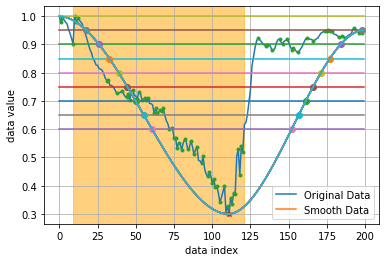

BGS show(200, 256, 256, 1)


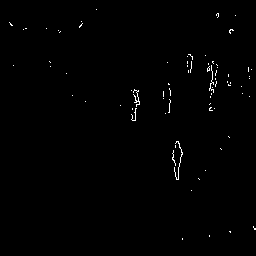

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test028 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(104, 199)]
GT Inverse Tuples: [(0, 104)]
Intersection
Multipoint
128.91193669070174 137.21300767456816 150.11024299818374 159.28338397104872 170.78719010485295 177.8699598732978
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   128.91193669070174 , 137.21300767456816
Reference p, q   =   104 , 199
Intersect x, y   =   150.11024299818374 , 159.28338397104872
Reference p, q   =   104 , 199
Intersect x, y   =   170.78719010485295 , 177.8699598732978
Reference p, q   =   104 , 199
Overlap: 24.556981725176257
============Find FPR============
Intersect x, y   =   128.91193669070174 , 137.21300767456816
Reference p, q   =   0 , 104
Intersect x, y   =   150.11024299818374 , 159.28338397104872
Reference p, q   =   0 , 104
Intersect x, y   =   170.78719010485295 , 177.8699598732978
Reference p, q  

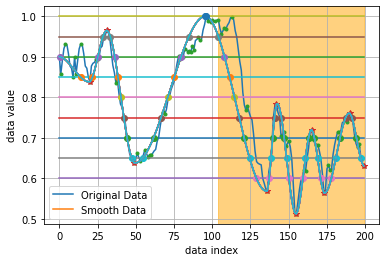

BGS show(200, 256, 256, 1)


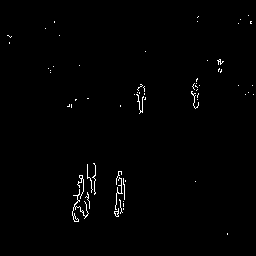

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test029 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 14), (44, 112)]
GT Inverse Tuples: [(14, 44), (112, 199)]
Intersection
Multipoint
2.9959678598814055 10.61051245881246 14.701442438537946 93.57036834701397 104.99381648030244
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   0.0 , 2.9959678598814055
Reference p, q   =   0 , 14
Reference p, q   =   44 , 112
Intersect x, y   =   10.61051245881246 , 14.701442438537946
Reference p, q   =   0 , 14
Reference p, q   =   44 , 112
Intersect x, y   =   93.57036834701397 , 104.99381648030244
Reference p, q   =   0 , 14
Reference p, q   =   44 , 112
Overlap: 17.80890353435742
============Find FPR============
Intersect x, y   =   0.0 , 2.9959678598814055
Reference p, q   =   14 , 44
Reference p, q   =   112 , 199
Intersect x, y   =   10.61051245881246 , 14.701442438537946
Reference p, q   =   14 , 

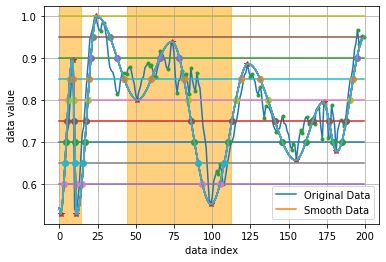

BGS show(200, 256, 256, 1)


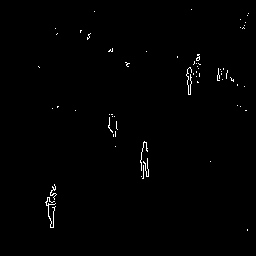

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test030 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(174, 199)]
GT Inverse Tuples: [(0, 174)]
Intersection
Point
178.8845051462341
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   178.8845051462341 , 199.0
Reference p, q   =   174 , 199
Overlap: 20.11549485376591
============Find FPR============
Intersect x, y   =   178.8845051462341 , 199.0
Reference p, q   =   0 , 174
Overlap: 0
TPR : 20.11549485376591
FPR : 0




Intersection
Point
176.21762112813838
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   176.21762112813838 , 199.0
Reference p, q   =   174 , 199
Overlap: 22.782378871861624
============Find FPR============
Intersect x, y   =   176.21762112813838 , 199.0
Reference p, q   =   0 , 174
Overlap: 0
TPR : 22.782378871861624
FPR : 0




Intersection
Point
173.63692169045166
____

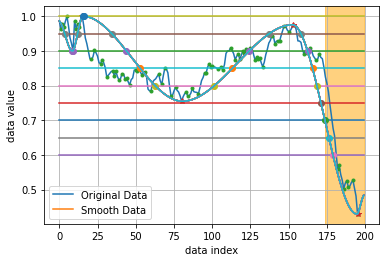

BGS show(200, 256, 256, 1)


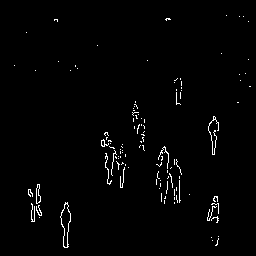

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test031 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 179)]
GT Inverse Tuples: [(179, 199)]
Intersection
Multipoint
39.899893001327435 57.971803869219265 95.34467746725196 150.27505715315294
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   39.899893001327435 , 57.971803869219265
Reference p, q   =   0 , 179
Intersect x, y   =   95.34467746725196 , 150.27505715315294
Reference p, q   =   0 , 179
Overlap: 73.00229055379282
============Find FPR============
Intersect x, y   =   39.899893001327435 , 57.971803869219265
Reference p, q   =   179 , 199
Intersect x, y   =   95.34467746725196 , 150.27505715315294
Reference p, q   =   179 , 199
Overlap: 0
TPR : 73.00229055379282
FPR : 0




Intersection
Multipoint
34.32698056554787 60.040759010186875 87.51979490690428 159.47134419666455
_________Find TPR FPR for Threshold : 0.65__________
==========

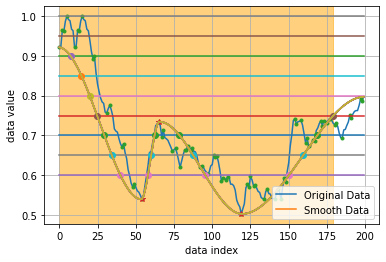

BGS show(200, 256, 256, 1)


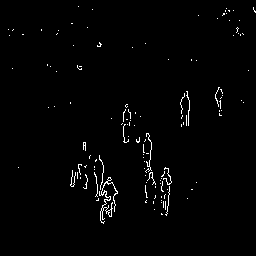

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test032 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 51), (64, 114)]
GT Inverse Tuples: [(51, 64), (114, 199)]
Intersection
Multipoint
29.177441140295652 35.81096809065605
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   29.177441140295652 , 35.81096809065605
Reference p, q   =   0 , 51
Reference p, q   =   64 , 114
Overlap: 6.633526950360395
============Find FPR============
Intersect x, y   =   29.177441140295652 , 35.81096809065605
Reference p, q   =   51 , 64
Reference p, q   =   114 , 199
Overlap: 0
TPR : 6.633526950360395
FPR : 0




Intersection
Multipoint
26.565059441161086 40.81570421788125
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   26.565059441161086 , 40.81570421788125
Reference p, q   =   0 , 51
Reference p, q   =   64 , 114
Overlap: 14.250644776720161
==========

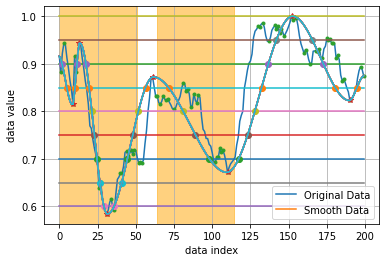

BGS show(200, 256, 256, 1)


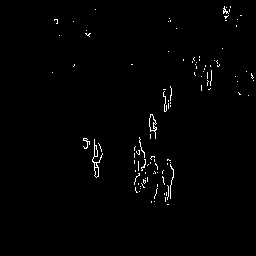

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test033 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(4, 164)]
GT Inverse Tuples: [(0, 4), (164, 199)]
Intersection
Multipoint
33.91980402706276 39.29529300148857 58.24902386905163 72.03895477410434 110.9924869808194 146.19155834150735
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   33.91980402706276 , 39.29529300148857
Reference p, q   =   4 , 164
Intersect x, y   =   58.24902386905163 , 72.03895477410434
Reference p, q   =   4 , 164
Intersect x, y   =   110.9924869808194 , 146.19155834150735
Reference p, q   =   4 , 164
Overlap: 54.364491240166466
============Find FPR============
Intersect x, y   =   33.91980402706276 , 39.29529300148857
Reference p, q   =   0 , 4
Reference p, q   =   164 , 199
Intersect x, y   =   58.24902386905163 , 72.03895477410434
Reference p, q   =   0 , 4
Reference p, q   =   164 , 199
Intersect x, y   =   110.992

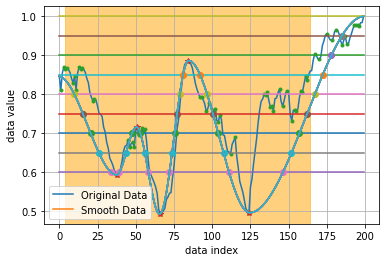

BGS show(200, 256, 256, 1)


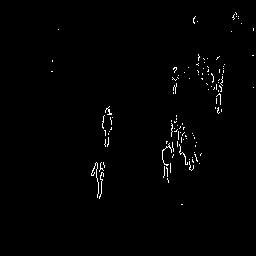

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test034 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(0, 120)]
GT Inverse Tuples: [(120, 199)]
Intersection
Multipoint
89.25944554398933 132.2556727803236
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   89.25944554398933 , 132.2556727803236
Reference p, q   =   0 , 120
Overlap: 30.74055445601067
============Find FPR============
Intersect x, y   =   89.25944554398933 , 132.2556727803236
Reference p, q   =   120 , 199
Overlap: 12.255672780323607
TPR : 30.74055445601067
FPR : 12.255672780323607




Intersection
Multipoint
84.77534721808284 139.98068908068362
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   84.77534721808284 , 139.98068908068362
Reference p, q   =   0 , 120
Overlap: 35.22465278191716
============Find FPR============
Intersect x, y   =   84.77534721808284 , 139.980689080

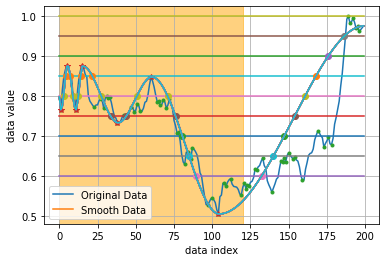

BGS show(200, 256, 256, 1)


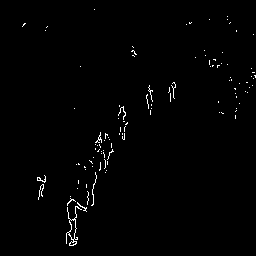

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test035 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(85, 199)]
GT Inverse Tuples: [(0, 85)]
Intersection
Multipoint
86.29918370786683 99.34358185852349 111.51144447306189 119.7860694788751
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   86.29918370786683 , 99.34358185852349
Reference p, q   =   85 , 199
Intersect x, y   =   111.51144447306189 , 119.7860694788751
Reference p, q   =   85 , 199
Overlap: 21.319023156469882
============Find FPR============
Intersect x, y   =   86.29918370786683 , 99.34358185852349
Reference p, q   =   0 , 85
Intersect x, y   =   111.51144447306189 , 119.7860694788751
Reference p, q   =   0 , 85
Overlap: 0
TPR : 21.319023156469882
FPR : 0




Intersection
Multipoint
81.96147551813637 101.72477737932667 108.17428746105597 122.53781108602811
_________Find TPR FPR for Threshold : 0.65__________
============Find TP

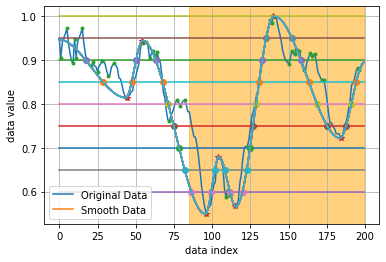

BGS show(200, 256, 256, 1)


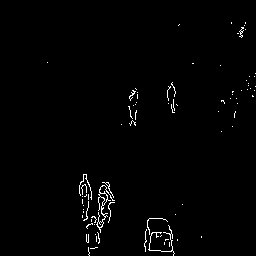

Test case loaded
Test cases shape: (200, 10, 256, 256, 1)
Test036 data set loaded
==============With BG Masked==============
(200,)
GT Tuples: [(14, 107)]
GT Inverse Tuples: [(0, 14), (107, 199)]
Intersection
Multipoint
53.290895572009795 121.17746346049925
_________Find TPR FPR for Threshold : 0.6__________
============Find TPR============
Intersect x, y   =   53.290895572009795 , 121.17746346049925
Reference p, q   =   14 , 107
Overlap: 53.709104427990205
============Find FPR============
Intersect x, y   =   53.290895572009795 , 121.17746346049925
Reference p, q   =   0 , 14
Reference p, q   =   107 , 199
Overlap: 14.177463460499254
TPR : 53.709104427990205
FPR : 14.177463460499254




Intersection
Multipoint
48.307609129508144 123.50473684114581
_________Find TPR FPR for Threshold : 0.65__________
============Find TPR============
Intersect x, y   =   48.307609129508144 , 123.50473684114581
Reference p, q   =   14 , 107
Overlap: 58.692390870491856
============Find FPR============
Int

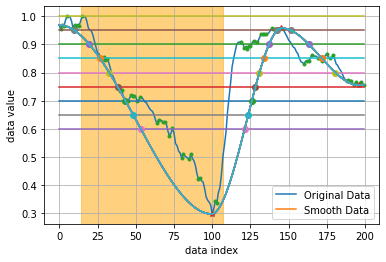

total_ref_gt_arr :[92, 125, 109, 137, 145, 189, 174, 93, 47, 139, 95, 70, 155, 199, 62, 77, 46, 66, 74, 130, 169, 91, 157, 121, 95, 67, 112, 95, 82, 25, 179, 101, 160, 120, 114, 93]
total_ref_gti_arr :[107, 74, 90, 62, 54, 10, 25, 106, 152, 60, 104, 129, 44, 0, 137, 122, 153, 133, 125, 69, 30, 108, 42, 78, 104, 132, 87, 104, 117, 174, 20, 98, 39, 79, 85, 106]




































































































































































































































































































































[4005. 4005. 4005. 4005. 4005. 4005. 4005. 4005. 4005.]
[3159. 3159. 3159. 3159. 3159. 3159. 3159. 3159. 3159.]
(9,)
(9,)


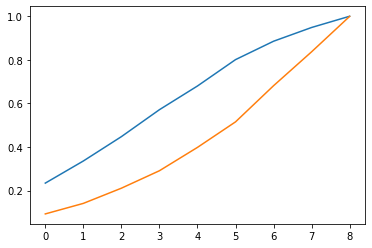

In [43]:
def build_model_aae():
  
    model_enc = load_model(conf.cwdir+"/model_gen_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    model_dec = load_model(conf.cwdir+"/model_dec_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    model_disc = load_model(conf.cwdir+"/model_dis_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})

    #model_enc = load_model("/content/drive/My Drive/model_gen_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_dec = load_model("/content/drive/My Drive/model_dec_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_disc = load_model("/content/drive/My Drive/model_dis_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})

    model_ae = Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)
    
    model_enc_disc = Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)
    
    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

model_enc.summary()
model_dec.summary()
model_disc.summary()
model_ae.summary()
model_enc_disc.summary()

model_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_enc_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_ae.compile(optimizer=Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), loss="mse")
#"/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/model.hdf5"

#model_ae = load_model("/content/drive/My Drive/VAE/model1.hdf5",custom_objects={'LayerNormalization': LayerNormalization})

def evaluate_dis(sequences, model, id, dt):
    fooling_loss = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    sa = (fooling_loss - np.min(fooling_loss)) / (np.max(fooling_loss))
    sr = 1.0 - sa

    with open(join("/content/drive/My Drive/", 'sr_score.csv'), mode='a') as f:
        writer = csv.writer(f)
        writer.writerow([float(x[0]) for x in sr])
        f.close()

    threshold_abs = threshold# np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        fill_gt_ped1(sr, id, 'red', threshold_abs)
    elif dt == 2:
        fill_gt_ped2(sr, id, 'red', threshold_abs)
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_dis(t)')
    #plt.xlabel('frame t')
    #plt.show()

def get_clips(test):
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :]
        sequences[i] = clip
    return sequences


def mask_array(bg_list):

    for p in range(0, bg_list.shape[0]):
        for r in range(256):
            for c in range(256):
                if bg_list[p][r][c] > 0:
                    bg_list[p][r][c] = 1
                else:
                    bg_list[p][r][c] = 0

    bg_list[0, :, :] = 0
    return bg_list

def evaluate_ae(sequences, model, id, dt, bg_list=[], mask=1):
  
    sz = len(sequences)

    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    #print(bg_list[10])

    masked_bg = mask_array(bg_list)
    bg_clips = get_clips(masked_bg)
    bg_clips = prepend_10_clips(bg_clips)
    sequences = np.reshape(sequences, (sequences.shape[0], sequences.shape[1], sequences.shape[2], sequences.shape[3]))
    reconstructed_sequences = np.reshape(reconstructed_sequences, (reconstructed_sequences.shape[0], reconstructed_sequences.shape[1], reconstructed_sequences.shape[2], reconstructed_sequences.shape[3]))

    if mask == 1:
        print("==============With BG Masked==============")
        sq_masked = np.multiply(sequences, bg_clips)
        rec_masked = np.multiply(reconstructed_sequences, bg_clips)
    else:
        print("==============Without BG Masked==============")
        sq_masked = sequences
        rec_masked = reconstructed_sequences

    #bg_weights = np.add(np.ones(bg_clips.shape), bg_clips)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sq_masked[i], rec_masked[i])) for i in range(0,sz)])
    #sequences_reconstruction_cost = np.array([np.linalg.norm(np.multiply(bg_weights[i],np.subtract(sequences[i], reconstructed_sequences[i]))) for i in range(0,sz)])


    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost))

    
    sr = 1 - sa
    #threshold_abs = threshold#np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = fill_gt_ped1(sr, id, 'orange')
    elif dt == 2:
        TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = fill_gt_ped2(sr, id, 'orange')
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_ae(t)')
    #plt.xlabel('frame t')
    #plt.show()
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti

def load_input_data_list():
    path = join("/content/drive/My Drive/", 'sr_score.csv')
    InputDataList = LoadData(path)
    return InputDataList


def get_persistance(InputData):
  #~ This simple call is all you need to compute the extrema of the given data and their persistence.
  ExtremaAndPersistence = RunPersistence(InputData)

  #~ Keep only those extrema with a persistence larger than 10.
  Filtered = [t for t in ExtremaAndPersistence if ExtremaAndPersistence[1] > 50]
  print(ExtremaAndPersistence)
  print(Filtered)
  #~ Sort the list of extrema by persistence.
  #Sorted = sorted(Filtered, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[1])

  return Filtered


conf.reconfig(new_name="Conv2DLSTM_AAE_PED1", batch_size=4, epochs=100, retrain=1)




def edge_detect(gray):
    edges1 = np.uint8(gray)
    # Using the Canny filter to get contours
    #edges = cv2.Canny(edges1, 20, 30)
    
    # Using the Canny filter with different parameters
    edges_high_thresh = cv2.Canny(edges1, 160, 200)
    kernel = np.zeros((5,5),np.uint8)
    kernel2 = np.zeros((2,2),np.uint8)

    images = cv2.morphologyEx(edges_high_thresh, cv2.MORPH_OPEN, kernel)
    images = cv2.morphologyEx(edges_high_thresh, cv2.MORPH_OPEN, kernel)
    images = cv2.morphologyEx(images, cv2.MORPH_CLOSE, kernel2)
    # Stacking the images to print them together
    # For comparison
    #images = np.hstack((gray, edges, edges_high_thresh))

    #kernel = np.ones((3,3), np.uint8) 
    #fg_mask = cv2.erode(edges_high_thresh, kernel, iterations=2)
    # Display the resulting frame
    #cv2_imshow(images)
    return images

    

def connected_comp(img):

    #find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    #connectedComponentswithStats yields every seperated component with information on each of them, such as size
    #the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
    sizes = stats[1:, -1]; nb_components = nb_components - 1

    # minimum size of particles we want to keep (number of pixels)
    #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
    min_size = 10  

    #your answer image
    img2 = np.zeros((output.shape))
    #for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255
    return img2

def get_background_subtr(test_case):
    print("BGS show" + str(np.array(test_case).shape))

    subtractor = cv2.createBackgroundSubtractorMOG2(history=50, varThreshold=50, detectShadows=True)
    bg_list = []
    for frame in test_case:
        frame = np.reshape(frame, (256, 256))*256
        edge_mask = edge_detect(frame)
        bg_mask = connected_comp(edge_mask)
        bg_mask = subtractor.apply(bg_mask)
        #edge_mask[0] = np.zeros(edge_mask[0].shape)
        #kernel = np.ones((5,5), np.uint8) 
        #fg_mask = cv2.erode(mask, kernel, iterations=2)
        #fg_mask = cv2.dilate(fg_mask, kernel, iterations=5)
        fg_mask = bg_mask/255.0
        #fg_mask = mask
        #cv2_imshow(fg_mask)
        #print(fg_mask)
        bg_list.append(fg_mask)
        #key = cv2.waitKey(30)
        #if key == 27:
        #    break
    cv2_imshow(bg_list[100]*255.0)
    #cv2.destroyAllWindows()
    #print(bg_list)
    return np.array(bg_list)


def show_bgs(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    return get_background_subtr(test)


TPR_FOR_CASES = []
FPR_FOR_CASES = []
total_ref_gt_arr = []
total_ref_gti_arr = []
#print(bg_list[10])
for i in range(1,37):
  if i < 10:
    img_num = "00"+str(i)
  elif i < 100:
    img_num = "0"+str(i)
  else:
    img_num = str(i) 

  #if img_num == "017":
  #  continue

  bg_list = show_bgs("Test"+img_num)
  
  
  test_cases_dir = "Test"+img_num
  test_cases = get_test_sequences(test_cases_dir)
  test_cases = np.array(prepend_10_clips(test_cases))
  print("Test cases shape: "+str(np.array(test_cases).shape))
  print("Test"+img_num+" data set loaded")
  #evaluate_dis(test_cases, model_enc_disc, i, 1)
  #sorted_sr = get_persistance(np.array([x[0] for x in sr_dis], dtype=float))
  #print(sorted_sr)
  #break
  TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = evaluate_ae(test_cases, model_ae, i, 1, bg_list, 1)
  TPR_FOR_CASES.append(TPR_ARR)
  FPR_FOR_CASES.append(FPR_ARR)
  total_ref_gt_arr.append(total_ref_gt)
  total_ref_gti_arr.append(total_ref_gti)
  
  #evaluate_ae(test_cases, model_ae, i, 1, bg_list, 0)

  #sr_comb = (sr_dis + sr_ae)*0.5
  #sr_comb = []

  continue

print("total_ref_gt_arr :"+str(total_ref_gt_arr))
print("total_ref_gti_arr :"+str(total_ref_gti_arr))


TPR_FOR_CASES = np.array(TPR_FOR_CASES)
FPR_FOR_CASES = np.array(FPR_FOR_CASES)
i=0
j=0
TPR_ADD = np.zeros((TPR_FOR_CASES[0].shape[0],))
TP_REF_ADD = np.zeros(TPR_ADD.shape) 
for id, TPR_CASE in enumerate(TPR_FOR_CASES):

    for i, __ in enumerate(TPR_CASE):
        TPR_ADD[i] = TPR_ADD[i]+TPR_CASE[i]
        print()
        TP_REF_ADD[i] = TP_REF_ADD[i]+total_ref_gt_arr[id]


id=0

FPR_ADD = np.zeros((FPR_FOR_CASES[0].shape[0],))
FP_REF_ADD = np.zeros(FPR_ADD.shape) 
for id, FPR_CASE in enumerate(FPR_FOR_CASES):

    for j, __ in enumerate(FPR_CASE):
        FPR_ADD[j] = FPR_ADD[j]+FPR_CASE[j]
        FP_REF_ADD[j] = FP_REF_ADD[j]+total_ref_gti_arr[id]


print(TP_REF_ADD)
print(FP_REF_ADD)

TPR_PLOT = np.divide(TPR_ADD, TP_REF_ADD)
FPR_PLOT = np.divide(FPR_ADD, FP_REF_ADD)

print(TPR_PLOT.shape)
print(FPR_PLOT.shape)

plt.plot(TPR_PLOT)
plt.plot(FPR_PLOT)
plt.show()

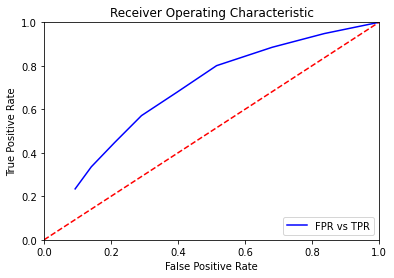

TPR
[0.23411318 0.33570878 0.44743947 0.57112548 0.67989854 0.80088749
 0.88534346 0.94843877 1.        ]
FPR
[0.0927948  0.14111213 0.21082629 0.29097436 0.39814936 0.51523703
 0.68122102 0.83689492 0.99936689]
AUC = 0.6765755782947102


In [44]:
plt.title('Receiver Operating Characteristic')
plt.plot(FPR_PLOT, TPR_PLOT, 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR_PLOT)
print("FPR")
print(FPR_PLOT)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area


print("AUC = "+str(integrate(FPR_PLOT, TPR_PLOT)))